### Import packages

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import networkx as nx
import math
%matplotlib inline

In [2]:
# Importation for data visualization
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts.charts import Bar
from pyecharts.charts import Line
from pyecharts import options as opts
# To control themes of pyecharts with pyecharts.globals.ThemeType
from pyecharts.globals import ThemeType
from pyecharts.render import make_snapshot
# Use snapshot-selenium Apply colours to a drawing pictures
from snapshot_selenium import snapshot

### Data preprocessing

In [3]:
# Functions to load original data and convert json data to list
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df=pd.read_csv(path)
    json_columns=['cast','crew']
    for column in json_columns:
        df[column]=df[column].apply(json.loads)
    return df

In [4]:
# Functions to extract names with specific job.
def extractName(column):
    col = [[di['name'] for di in row] for row in column]
    return col

def extractDirector(crew, job):
    name = ''
    for di in crew:
        if di['job'] == job:
            name = di['name']
            break 
        else:
            pass
    return name

def extractCrew(crew, job):
    name = []
    for di in crew:
        if di['job'] == job:
            name_buf = di['name']
            name.append(name_buf)
        else:
            pass
    return name



In [5]:
path_data = 'tmdb_5000_movies.csv'
path_credits = 'tmdb_5000_credits.csv'
movie_data = load_tmdb_movies(path_data)
movie_credit = load_tmdb_credits(path_credits)

Merge two datasets by movie_id into the new file ```movie_combine```.

In [6]:
movie_combine = pd.merge(movie_data,movie_credit,left_on='id',right_on='movie_id',how='inner')

In [7]:
# Drop columns we don't need
movie_drp = movie_combine
movie_drp.drop(['homepage','original_title','overview','tagline','title_y','movie_id', 'keywords'
               ],axis=1,inplace=True)
movie_drp.rename(columns={'title_x': 'title'}, inplace = True)

Locate "null" data.

In [8]:
movie_drp.loc[movie_drp['runtime'].isnull()==True]

,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
2656,15000000,"[{'id': 18, 'name': 'Drama'}]",370980,it,0.738646,"[{'name': 'Taodue Film', 'id': 45724}]","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2015-12-03,0,NaN,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,Chiamatemi Francesco - Il Papa della gente,7.3,12,"[{'cast_id': 5, 'character': 'Jorge Mario Berg...","[{'credit_id': '5660019ac3a36875f100252b', 'de..."
4140,2,"[{'id': 99, 'name': 'Documentary'}]",459488,en,0.050625,"[{'name': 'Eyeline Entertainment', 'id': 60343}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2015-12-12,0,NaN,[],Released,"To Be Frank, Sinatra at 100",0.0,0,"[{'cast_id': 0, 'character': 'Narrator', 'cred...","[{'credit_id': '592b25e4c3a368783e065a2f', 'de..."


In [9]:
movie_drp.loc[movie_drp['release_date'].isnull()==True]

,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
4553,0,[],380097,en,0.0,[],[],NaT,0,0.0,[],Released,America Is Still the Place,0.0,0,[],[]


In [10]:
# Fill in "null" data by searching in Internet
movie_drp['release_date'].fillna(pd.to_datetime('2015-03-01'), inplace=True)
movie_drp['runtime'].fillna(98,limit = 1,inplace=True)
movie_drp['runtime'].fillna(81,inplace=True)

In [11]:
#Extract main 5 actors, director and producer
ex_name = ['genres', 'production_companies', 'production_countries']
for column in ex_name:
    movie_drp[column] = extractName(movie_drp[column])
movie_drp['actors'] = [[di['name'] for di in row[0:5]] for row in movie_drp['cast']]    #演员只取前4位
# Creat new column of director.
movie_drp['director'] = [extractDirector(crew, 'Director') for crew in movie_drp.crew]
movie_drp['Producers'] = [extractCrew(crew, 'Producer') for crew in movie_drp.crew]

In [12]:
#From release_date extract year
movie_drp['year'] = pd.to_datetime(movie_drp['release_date']).dt.year

In [13]:
# Drop out movies not released
movie_ul = movie_drp
movie_ul.drop(movie_ul[movie_ul.status == 'Rumored'].index, inplace=True)
movie_ul.drop(movie_ul[movie_ul.status == 'Post Production'].index, inplace=True)

Creat new columns needed. For the movies dataframe, we removed movies that we don't need and has missing(unrepresentative) information.   The name of the first genre is kept in the column "genre_main". One "ROI" column ($ROI=\frac{revenue-budget}{budget}$) and "success" column are added to do further analysis. 

In [15]:
# Creat new column contains the first genre and assign index for different genres
movie_ul['genre_main'] = [row[0] if row else 'No genre' for row in movie_ul['genres']]
factorized_names = pd.factorize(movie_ul['genre_main'])
movie_ul['genre_id'] = factorized_names[0]

In [16]:
# Add ROI column
ROI = (movie_ul['revenue'] - movie_ul['budget']).divide(movie_ul['budget'])
movie_ul['ROI'] = ROI

In [17]:
# Add success label column
label_scs = movie_ul['ROI'].copy()
threshold = 0.6
label_scs[label_scs < threshold] = 0
label_scs[label_scs >= threshold] = 1
movie_ul['success'] = label_scs

In [19]:
movie_ul.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,year,genre_id,ROI,success
count,4.795000e+03,4795.000000,4795.000000,4.795000e+03,4795.000000,4795.000000,4795.000000,4795.000000,4795.000000,3910.000000,3910.000000
mean,2.909267e+07,57051.887800,21.527415,8.239771e+07,106.907821,6.093306,691.360792,2002.459228,6.150156,inf,0.561125
std,4.073962e+07,88593.489117,31.831547,1.629583e+08,22.569104,1.190313,1235.298140,12.420249,4.667722,NaN,0.496313
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1916.000000,0.000000,-1.000000,0.000000
25%,8.000000e+05,9010.500000,4.723880,0.000000e+00,94.000000,5.600000,54.000000,1999.000000,2.000000,-0.448849,0.000000
50%,1.500000e+07,14585.000000,12.963328,1.925587e+07,103.000000,6.200000,236.000000,2005.000000,5.000000,1.000000,1.000000
75%,4.000000e+07,58533.000000,28.352222,9.311911e+07,118.000000,6.800000,738.000000,2011.000000,8.000000,3.331678,1.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,2017.000000,20.000000,inf,1.000000


### Graph construction from 2000 to 2016

We drop out movies whose vote count is lower than 40 and which has unnormal data in budget and revenue. The criterion is in the below cell.

In [20]:
# Drop useless row
movie_p1 = movie_ul[(movie_ul.year >= 2000) & (movie_ul.year < 2017) & (movie_ul.vote_count > 40)
                    &(movie_ul.budget >=100000) &(movie_ul.budget * movie_ul.revenue * movie_ul.vote_average !=0)].reset_index(drop = 'True')

In [21]:
#Assign a new movie index to replace the current movie index
new_movie_index = np.arange(movie_p1.shape[0])
movie_p1['id'] = new_movie_index

In [22]:
# Drop out useless columns
movie_p1.drop(['crew','cast','original_language','spoken_languages','production_companies','production_countries'],axis=1,inplace=True)

In [24]:
actors_p1 = movie_p1.actors.copy()
#actors_genre = pd.concat([actors,movie_p1['genre_id']],axis=1) 

In [25]:
# Creat actors set in this period
list_actors_rep_p1 = []
for i in actors_p1:
    list_actors_rep_p1.extend(i)
set_actor_raw_p1 = set(list_actors_rep_p1)
set_actor_filtered_p1 = []
th_ca_p1 = 2
for one in set_actor_raw_p1:
    if list_actors_rep_p1.count(one) >= th_ca_p1:
        set_actor_filtered_p1.append(one)

In [27]:
# Creat actors dataframe in this period
df_actors_filtered_p1 = pd.DataFrame(set_actor_filtered_p1)
factorized_actor_names_p1 = pd.factorize(df_actors_filtered_p1[0])
df_actors_filtered_p1['actor_id'] = factorized_actor_names_p1[0]

```feature_p1``` is the actors feature matrix of period 1. From 2000 to 2016 we have 2157 movies and 1654 actors as features in total to analyze.

In [28]:
#Create a feature table 
list_set_fltered_p1 = list(set_actor_filtered_p1)
movie_actors_p1 = pd.DataFrame()
for i in list_set_fltered_p1:
    movie_actors_p1[i]=actors_p1.apply(lambda x:1 if i in x else 0)
features_p1 = movie_actors_p1.to_numpy()
features_p1.shape

(2157, 1654)

```distance_p1``` is the distance matrix of period 1 measuring distance between nodes in ```feature_p1```.

In [29]:
num_nodes_p1 = features_p1.shape[0]
distance_p1 = np.zeros((num_nodes_p1,num_nodes_p1))

for row in range(num_nodes_p1):
    for row2 in range(num_nodes_p1):
        distance_p1[row,row2] = np.sqrt(((features_p1[row,:]-features_p1[row2,:])**2).sum())
        
distance_p1.shape

(2157, 2157)

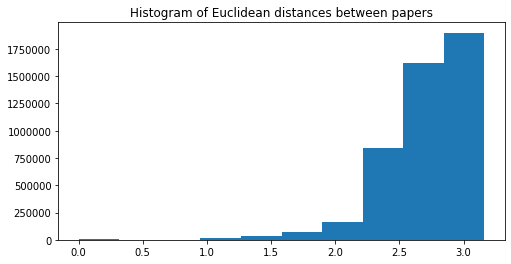

In [31]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance_p1.flatten());

Set the similarity threshold under which to add an edge between nodes. 

In [32]:
#threshold = mean_distance
threshold = 1.8 #有2个演员相同
A_feature_p1 = (distance_p1 <= threshold).astype(float) - np.eye(distance_p1.shape[0])

In [33]:
num_edges_feature_p1 = A_feature_p1.sum() / 2
print(f"Number of edges in the feature graph from 2000 to 2016: {num_edges_feature_p1}")

Number of edges in the feature graph from 2000 to 2016: 59622.0


(array([0.84886416, 0.        , 0.07278628, 0.        , 0.        ,
        0.05146036, 0.        , 0.        , 0.        , 0.0268892 ]),
 array([  0. ,  64.1, 128.2, 192.3, 256.4, 320.5, 384.6, 448.7, 512.8,
        576.9, 641. ]),
 <a list of 10 Patch objects>)

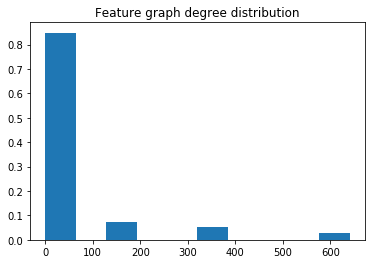

In [34]:
degrees_feature_p1 = A_feature_p1.sum(1)
deg_hist_normalization_p1 = np.ones(degrees_feature_p1.shape[0]) / degrees_feature_p1.shape[0]
plt.title('Feature graph degree distribution')
plt.hist(degrees_feature_p1, weights = deg_hist_normalization_p1)

In [35]:
degfs_p1, counts_feat_p1 = np.unique(degrees_feature_p1, return_counts=True)
degfeatprobs_p1 = counts_feat_p1 / counts_feat_p1.sum()
feat_moment_1_p1 = (degfs_p1*degfeatprobs_p1).sum()
feat_moment_2_p1 = (degfs_p1*degfs_p1*degfeatprobs_p1).sum()
print(f"1st moment of feature graph: {feat_moment_1_p1}")
print(f"2nd moment of feature graph: {feat_moment_2_p1}")

1st moment of feature graph: 55.28233657858136
2nd moment of feature graph: 19172.203059805284


Plot adjacency matrix

Text(0.5, 1.05, 'Feature graph: adjacency matrix sparsity pattern')

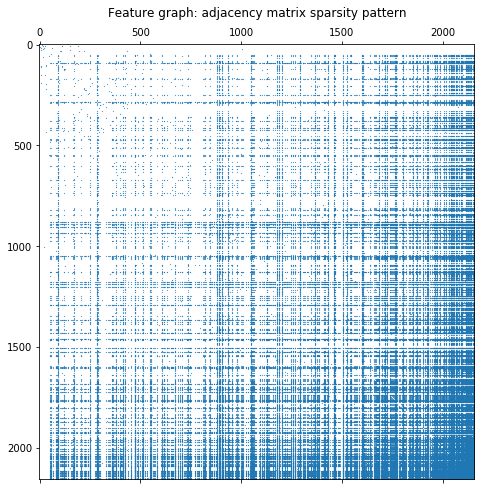

In [36]:
plt.figure(1, figsize=(8, 8))
plt.spy(A_feature_p1, markersize = 0.2)
plt.title('Feature graph: adjacency matrix sparsity pattern')

Compute connected components and their properties of graph we built in period one.

In [39]:
G_feature_p1 = nx.from_numpy_matrix(A_feature_p1)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature_p1.number_of_nodes(), G_feature_p1.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_feature_p1), nx.number_connected_components(G_feature_p1)))

Number of nodes: 2157, Number of edges: 59622
Number of self-loops: 0, Number of connected components: 1287


In [38]:
Gcc_p1 = sorted(nx.connected_components(G_feature_p1), key=len, reverse=True)
Gc_p1 = G_feature_p1.subgraph(Gcc_p1[0])
print('The giant component of the feature graph has {} nodes and {} edges.'.format(Gc_p1.number_of_nodes(), Gc_p1.size()))

The giant component of the feature graph has 789 nodes and 59523 edges.


Graph visualization with genre label 

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 2000 to 2016(Label: Genre)')

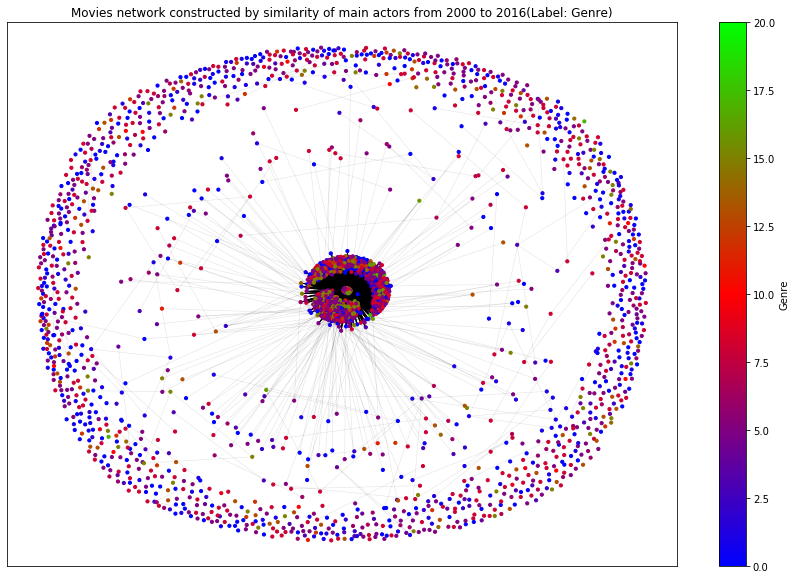

In [41]:
pos = nx.spring_layout(G_feature_p1, k=0.2)  # Force-directed layout.
# 
fig_mov_gen_p1 = plt.figure(figsize=(15, 10))
labels_genre = movie_p1['genre_id'].iloc[np.sort(nx.nodes(G_feature_p1))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p1, pos, node_size=10, node_color=labels_genre, cmap='brg',vmin=0, vmax=20)
cbar = plt.colorbar(img)
cbar.set_label('Genre')
nx.draw_networkx_edges(G_feature_p1, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 2000 to 2016(Label: Genre)')
#fig_mov_gen_p1.savefig('./Figure/movie_gen_p1.png')

Graph visualization with success label 

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 2000 to 2016(Label: Success Label)')

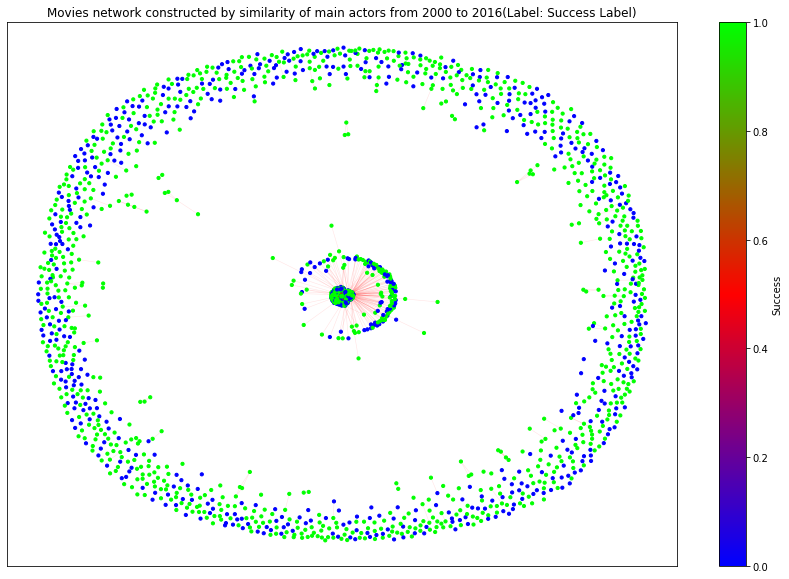

In [42]:
pos = nx.spring_layout(G_feature_p1, k=0.05)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_suc = movie_p1['success'].iloc[np.sort(nx.nodes(G_feature_p1))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p1, pos, node_size=10, node_color=labels_suc, cmap='brg',vmin=0, vmax=1)
cbar = plt.colorbar(img)
cbar.set_label('Success')
nx.draw_networkx_edges(G_feature_p1, pos, alpha=0.1,edge_color='r', width=0.6)
plt.title('Movies network constructed by similarity of main actors from 2000 to 2016(Label: Success Label)')

Compare success ratio between the giant component and the total movie set in this period.

In [43]:
labels_suc_total_p1 = movie_p1['success'].iloc[np.sort(nx.nodes(G_feature_p1))]
r_suc_total_p1 = sum(labels_suc_total_p1)/len(labels_suc_total_p1)
labels_suc_Gc_p1 = movie_p1['success'].iloc[np.sort(nx.nodes(Gc_p1))]
r_suc_Gc_p1 = sum(labels_suc_Gc_p1)/len(labels_suc_Gc_p1)
print('The success ratio in total is {} and the success ratio of the Giant component is {}.'.format(r_suc_total_p1, r_suc_Gc_p1))

The success ratio in total is 0.6328233657858137 and the success ratio of the Giant component is 0.6273764258555133.


Graph visualization with success label 

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 2000 to 2016(Label: ROI)')

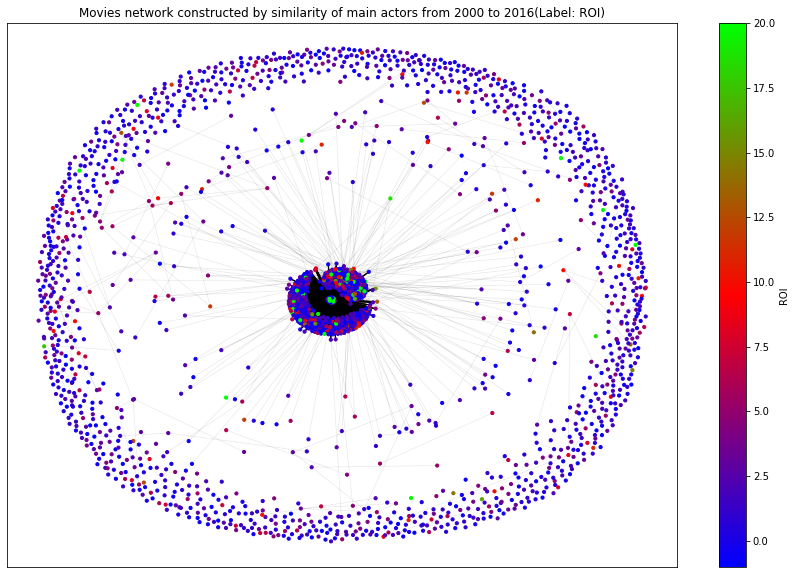

In [45]:
pos = nx.spring_layout(G_feature_p1, k=0.2)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_ROI = movie_p1['ROI'].iloc[np.sort(nx.nodes(G_feature_p1))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p1, pos, node_size=10, node_color=labels_ROI, cmap='brg',vmin=-1, vmax=20)
cbar = plt.colorbar(img)
cbar.set_label('ROI')
nx.draw_networkx_edges(G_feature_p1, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 2000 to 2016(Label: ROI)')

Compare average ROI between the giant component and the total movie set in this period.

In [46]:
labels_ROI_total_p1 = movie_p1['ROI'].iloc[np.sort(nx.nodes(G_feature_p1))]
ROI_avr_total_p1 = sum(labels_ROI_total_p1)/len(labels_ROI_total_p1)
labels_ROI_Gc_p1 = movie_p1['ROI'].iloc[np.sort(nx.nodes(Gc_p1))]
ROI_avr_Gc_p1 = sum(labels_ROI_Gc_p1)/len(labels_ROI_Gc_p1)
print('The average ROI in total is {} and the average ROI of the Giant component is {}.'.format(ROI_avr_total_p1, ROI_avr_Gc_p1))

The average ROI in total is 3.0457686545378317 and the average ROI of the Giant component is 4.9289883030831945.


Graph visualization with average score label 

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 2000 to 2016(Label: Average Score)')

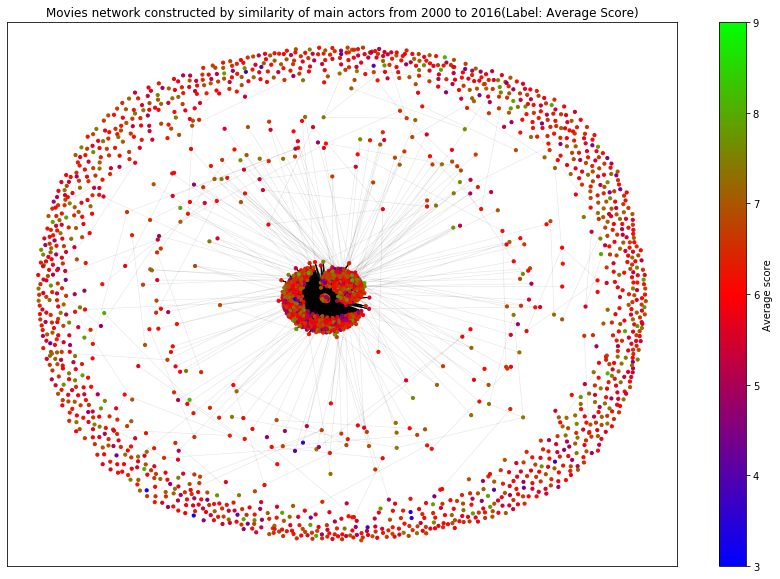

In [47]:
pos = nx.spring_layout(G_feature_p1, k=0.2)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_score = movie_p1['vote_average'].iloc[np.sort(nx.nodes(G_feature_p1))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p1, pos, node_size=10, node_color=labels_score, cmap='brg',vmin=3, vmax=9)
cbar = plt.colorbar(img)
cbar.set_label('Average score')
nx.draw_networkx_edges(G_feature_p1, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 2000 to 2016(Label: Average Score)')

Compare average score between the giant component and the total movie set in this period.

In [48]:
labels_score_total_p1 = movie_p1['vote_average'].iloc[np.sort(nx.nodes(G_feature_p1))]
score_avr_total_p1 = sum(labels_score_total_p1)/len(labels_score_total_p1)
labels_score_Gc_p1 = movie_p1['vote_average'].iloc[np.sort(nx.nodes(Gc_p1))]
score_avr_Gc_p1 = sum(labels_score_Gc_p1)/len(labels_score_Gc_p1)
print('The average score in total is {} and the average score of the Giant component is {}.'.format(score_avr_total_p1, score_avr_Gc_p1))

The average score in total is 6.247844228094573 and the average score of the Giant component is 6.262484157160969.


Visualization of the giant component in this network

In [49]:
Gcc1_p1 = G_feature_p1.subgraph(Gcc_p1[0])

Text(0.5, 1.0, 'Giant component of movies network constructed by similarity of main actors from 2000 to 2016(Label: Genre)')

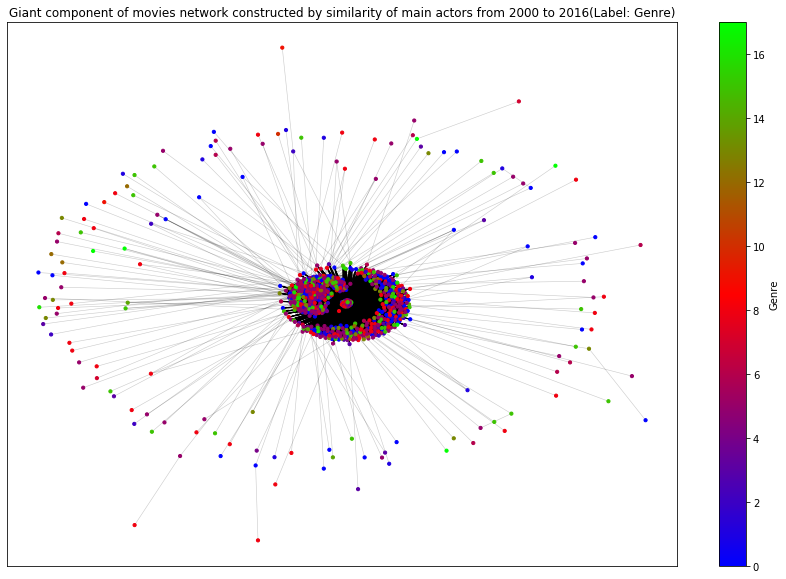

In [51]:
pos = nx.spring_layout(Gc_p1, k=0.2)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_genre = movie_p1['genre_id'].iloc[np.sort(nx.nodes(Gc_p1))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(Gc_p1, pos, node_size=10, node_color=labels_genre, cmap='brg',vmin=0, vmax=17)
cbar = plt.colorbar(img)
cbar.set_label('Genre')
nx.draw_networkx_edges(Gc_p1, pos, alpha=0.2, width=0.6)
plt.title('Giant component of movies network constructed by similarity of main actors from 2000 to 2016(Label: Genre)')

### Graph construction from 1980 to 1999

We drop out movies whose vote count is lower than 40 and which has unnormal data in budget and revenue. The criterion is in the below cell.

In [53]:
# Drop useless row
movie_p2 = movie_ul[(movie_ul.year >= 1980) & (movie_ul.year < 2000) & (movie_ul.vote_count > 40)
                    &(movie_ul.budget >=100000) &(movie_ul.budget * movie_ul.revenue * movie_ul.vote_average !=0)].reset_index(drop = 'True')

In [54]:
#Assign a new movie index to replace the current movie index
new_movie_index_p2 = np.arange(movie_p2.shape[0])
movie_p2['id'] = new_movie_index_p2

In [55]:
movie_p2.drop(['crew','cast','original_language','spoken_languages','production_companies','production_countries'],axis=1,inplace=True)

In [56]:
actors_p2 = movie_p2.actors.copy()
list_actors_rep_p2 = []
for i in actors_p2:
    list_actors_rep_p2.extend(i)
set_actor_raw_p2 = set(list_actors_rep_p2)
set_actor_filtered_p2 = []
th_ca_p2 = 2
for one in set_actor_raw_p2:
    if list_actors_rep_p2.count(one) >= th_ca_p2:
        set_actor_filtered_p2.append(one)    

```feature_p2``` is the actors feature matrix of period 1. From 1980 to 1999 we have 674 movies and 661 actors as features in total to analyze.

In [57]:
#Create a table 
list_set_fltered_p2 = list(set_actor_filtered_p2)
movie_actors_p2 = pd.DataFrame()
for i in list_set_fltered_p2:
    movie_actors_p2[i]=actors_p2.apply(lambda x:1 if i in x else 0)
features_p2 = movie_actors_p2.to_numpy()
features_p2.shape    

(674, 661)

```distance_p2``` is the distance matrix of period 1 measuring distance between nodes in ```feature_p2```.

In [59]:
num_nodes_p2 = features_p2.shape[0]
distance_p2 = np.zeros((num_nodes_p2,num_nodes_p2))

for row in range(num_nodes_p2):
    for row2 in range(num_nodes_p2):
        distance_p2[row,row2] = np.sqrt(((features_p2[row,:]-features_p2[row2,:])**2).sum())
        
distance_p2.shape

(674, 674)

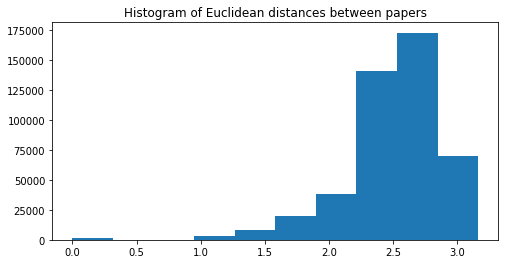

In [60]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance_p2.flatten());

In [61]:
# We set similar threshold
th_p2 = 1.8 #有2个演员相同
A_feature_p2 = (distance_p2 <= th_p2).astype(float) - np.eye(distance_p2.shape[0])

In [62]:
num_edges_feature_p2 = A_feature_p2.sum() / 2
print(f"Number of edges in the feature graph from 1980 to 1999: {num_edges_feature_p2}")

Number of edges in the feature graph from 1980 to 1999: 15853.0


(array([0.73590504, 0.        , 0.14836795, 0.        , 0.        ,
        0.0727003 , 0.        , 0.        , 0.        , 0.04302671]),
 array([  0. ,  34.1,  68.2, 102.3, 136.4, 170.5, 204.6, 238.7, 272.8,
        306.9, 341. ]),
 <a list of 10 Patch objects>)

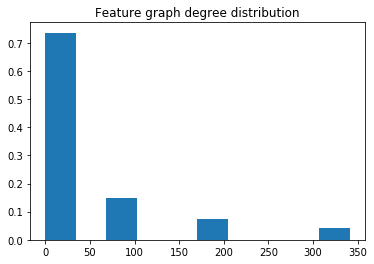

In [64]:
degrees_feature_p2 = A_feature_p2.sum(1)
deg_hist_normalization_p2 = np.ones(degrees_feature_p2.shape[0]) / degrees_feature_p2.shape[0]
plt.title('Feature graph degree distribution')
plt.hist(degrees_feature_p2, weights = deg_hist_normalization_p2)

Text(0.5, 1.05, 'Feature graph: adjacency matrix sparsity pattern')

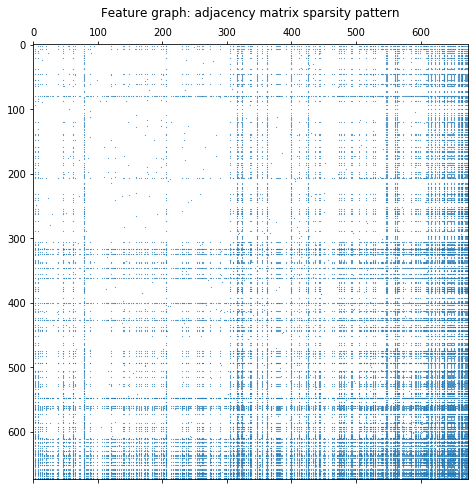

In [65]:
plt.figure(1, figsize=(8, 8))
plt.spy(A_feature_p2, markersize = 0.2)
plt.title('Feature graph: adjacency matrix sparsity pattern')

In [66]:
G_feature_p2 = nx.from_numpy_matrix(A_feature_p2)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature_p2.number_of_nodes(), G_feature_p2.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_feature_p2), nx.number_connected_components(G_feature_p2)))

Number of nodes: 674, Number of edges: 15853
Number of self-loops: 0, Number of connected components: 276


In [67]:
Gcc_p2 = sorted(nx.connected_components(G_feature_p2), key=len, reverse=True)
Gc_p2 = G_feature_p2.subgraph(Gcc_p2[0])
print('The giant component of the feature graph has {} nodes and {} edges.'.format(Gc_p2.number_of_nodes(), Gc_p2.size()))

The giant component of the feature graph has 385 nodes and 15831 edges.


Graphs below are organized in the same order as we did in period one so please refer to the above annotation of period 1. 

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 1980 to 1999(Label: Genre)')

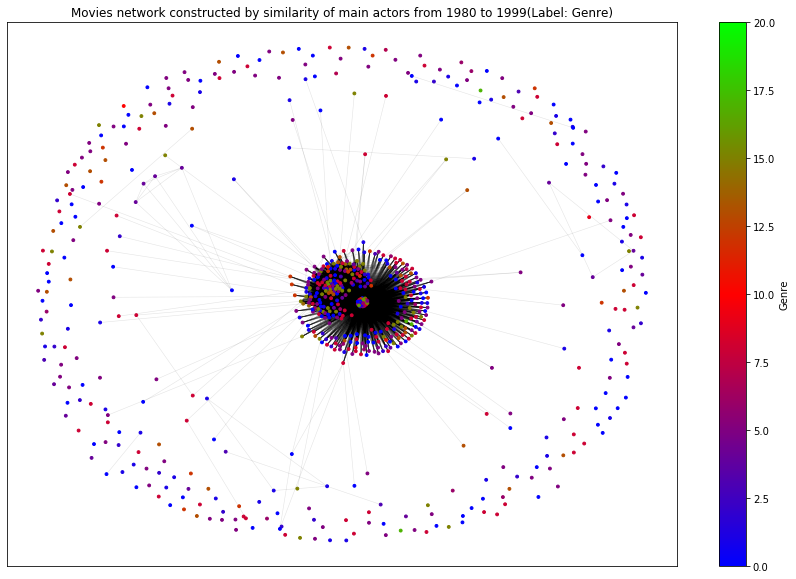

In [68]:
pos = nx.spring_layout(G_feature_p2, k=0.3)  # Force-directed layout.
# 
fig_mov_gen_p2 = plt.figure(figsize=(15, 10))
labels_genre_p2 = movie_p2['genre_id'].iloc[np.sort(nx.nodes(G_feature_p2))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p2, pos, node_size=8, node_color=labels_genre_p2, cmap='brg',vmin=0, vmax=20)
cbar = plt.colorbar(img)
cbar.set_label('Genre')
nx.draw_networkx_edges(G_feature_p2, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 1980 to 1999(Label: Genre)')
#fig_mov_gen_p2.savefig('./Figure/movie_gen_p2.png')

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 1980 to 1999(Label: Success Label)')

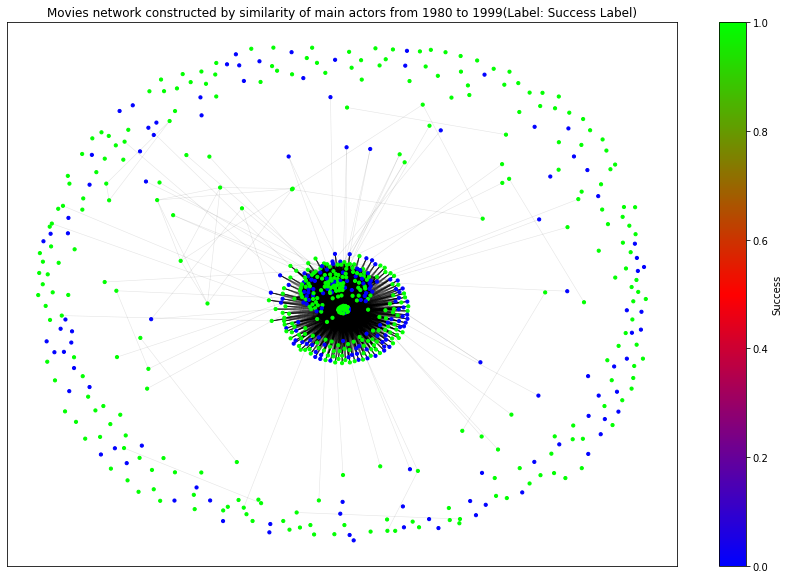

In [70]:
pos = nx.spring_layout(G_feature_p2, k=0.3)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_suc_p2 = movie_p2['success'].iloc[np.sort(nx.nodes(G_feature_p2))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p2, pos, node_size=10, node_color=labels_suc_p2, cmap='brg',vmin=0, vmax=1)
cbar = plt.colorbar(img)
cbar.set_label('Success')
nx.draw_networkx_edges(G_feature_p2, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 1980 to 1999(Label: Success Label)')

In [71]:
labels_suc_total_p2 = movie_p2['success'].iloc[np.sort(nx.nodes(G_feature_p2))]
r_suc_total_p2 = sum(labels_suc_total_p2)/len(labels_suc_total_p2)
labels_suc_Gc_p2 = movie_p2['success'].iloc[np.sort(nx.nodes(Gc_p2))]
r_suc_Gc_p2 = sum(labels_suc_Gc_p2)/len(labels_suc_Gc_p2)
print('The success ratio in total is {} and the success ratio of the Giant component is {}.'.format(r_suc_total_p2, r_suc_Gc_p2))

The success ratio in total is 0.6810089020771514 and the success ratio of the Giant component is 0.6571428571428571.


List top successful genres in the giant component and the total movie set.

In [72]:
labels_suc_total_p2 = movie_p2['genre_main'].iloc[np.sort(nx.nodes(Gc_p2))]
pd.value_counts(labels_suc_total_p2)

Comedy             77
Drama              75
Action             70
Horror             48
Adventure          37
Crime              18
Fantasy            12
Science Fiction    10
Romance            10
Thriller            8
Animation           6
Mystery             5
Music               3
Western             2
Documentary         2
History             1
Family              1
Name: genre_main, dtype: int64

In [73]:
labels_suc_tota = movie_p2['genre_main'].iloc[np.sort(nx.nodes(G_feature_p2))]
pd.value_counts(labels_suc_tota)

Drama              143
Action             135
Comedy             118
Adventure           71
Horror              58
Crime               37
Fantasy             26
Science Fiction     24
Romance             18
Thriller            14
Animation           10
Mystery              5
Music                5
Family               3
Documentary          2
Western              2
History              2
War                  1
Name: genre_main, dtype: int64

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 1980 to 2000(Label: ROI)')

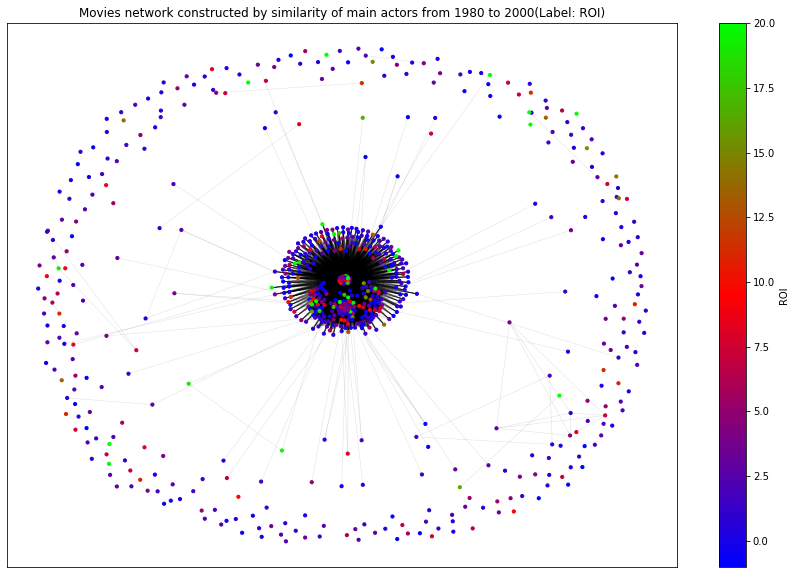

In [78]:
pos = nx.spring_layout(G_feature_p2, k=0.3)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_ROI_p2 = movie_p2['ROI'].iloc[np.sort(nx.nodes(G_feature_p2))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p2, pos, node_size=10, node_color=labels_ROI_p2, cmap='brg',vmin=-1, vmax=20)
cbar = plt.colorbar(img)
cbar.set_label('ROI')
nx.draw_networkx_edges(G_feature_p2, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 1980 to 2000(Label: ROI)')

In [79]:
labels_ROI_total_p2 = movie_p2['ROI'].iloc[np.sort(nx.nodes(G_feature_p2))]
ROI_avr_total_p2 = sum(labels_ROI_total_p2)/len(labels_ROI_total_p2)
labels_ROI_Gc_p2 = movie_p2['ROI'].iloc[np.sort(nx.nodes(Gc_p2))]
ROI_avr_Gc_p2 = sum(labels_ROI_Gc_p2)/len(labels_ROI_Gc_p2)
print('The average ROI in total is {} and the average ROI of the Giant component is {}.'.format(ROI_avr_total_p2, ROI_avr_Gc_p2))

The average ROI in total is 4.089688739478886 and the average ROI of the Giant component is 4.557429318239397.


In [80]:
labels_score_total_p2 = movie_p2['vote_average'].iloc[np.sort(nx.nodes(G_feature_p2))]
score_avr_total_p2 = sum(labels_score_total_p2)/len(labels_score_total_p2)
labels_score_Gc_p2 = movie_p2['vote_average'].iloc[np.sort(nx.nodes(Gc_p2))]
score_avr_Gc_p2 = sum(labels_score_Gc_p2)/len(labels_score_Gc_p2)
print('The average score in total is {} and the average score of the Giant component is {}.'.format(score_avr_total_p2, score_avr_Gc_p2))

The average score in total is 6.470771513353121 and the average score of the Giant component is 6.422077922077924.


### 3.Analysis from 1910 to 1979

The same operation as we do in last two periods, annotaion is available only at cell newly appears

In [82]:
# Drop useless row
movie_p3 = movie_ul[(movie_ul.year >= 1910) & (movie_ul.year < 1980) & (movie_ul.vote_count > 40)
                    &(movie_ul.budget >=10000) &(movie_ul.budget * movie_ul.revenue * movie_ul.vote_average !=0)].reset_index(drop = 'True')

In [83]:
#Assign a new movie index to replace the current movie index
new_movie_index_p3 = np.arange(movie_p3.shape[0])
movie_p3['id'] = new_movie_index_p3

In [84]:
movie_p3.drop(['crew','cast','original_language','spoken_languages','production_companies','production_countries'],axis=1,inplace=True)

In [85]:
actors_p3 = movie_p3.actors.copy()
list_actors_rep_p3 = []
for i in actors_p3:
    list_actors_rep_p3.extend(i)
set_actor_raw_p3 = set(list_actors_rep_p3)
set_actor_filtered_p3 = []
th_ca_p3 = 2
for one in set_actor_raw_p3:
    if list_actors_rep_p3.count(one) >= th_ca_p3:
        set_actor_filtered_p3.append(one)    

```feature_p3``` is the actors feature matrix of period 1. From 1910 to 1979 we have 162 movies and 115 actors as features in total to analyze.

In [86]:
#Create a table 
list_set_fltered_p3 = list(set_actor_filtered_p3)
movie_actors_p3 = pd.DataFrame()
for i in list_set_fltered_p3:
    movie_actors_p3[i]=actors_p3.apply(lambda x:1 if i in x else 0)
features_p3 = movie_actors_p3.to_numpy()
features_p3.shape    

(162, 115)

In [87]:
num_nodes_p3 = features_p3.shape[0]
distance_p3 = np.zeros((num_nodes_p3,num_nodes_p3))

for row in range(num_nodes_p3):
    for row2 in range(num_nodes_p3):
        distance_p3[row,row2] = np.sqrt(((features_p3[row,:]-features_p3[row2,:])**2).sum())
        
distance_p3.shape

(162, 162)

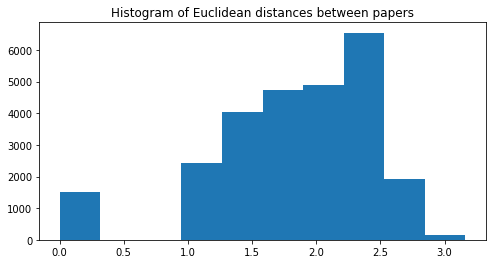

In [88]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance_p3.flatten());

In [89]:
th_p3 = 1.8 
A_feature_p3 = (distance_p3 <= th_p3).astype(float) - np.eye(distance_p3.shape[0])

In [90]:
num_edges_feature_p3 = A_feature_p3.sum() / 2
print(f"Number of edges in the feature graph from 1910 to 1979: {num_edges_feature_p3}")

Number of edges in the feature graph from 1910 to 1979: 6281.0


(array([0.14814815, 0.        , 0.15432099, 0.02469136, 0.        ,
        0.24691358, 0.        , 0.16049383, 0.03703704, 0.22839506]),
 array([  0. ,  13.7,  27.4,  41.1,  54.8,  68.5,  82.2,  95.9, 109.6,
        123.3, 137. ]),
 <a list of 10 Patch objects>)

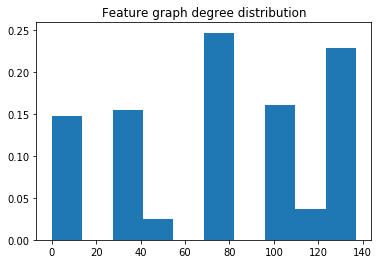

In [91]:
degrees_feature_p3 = A_feature_p3.sum(1)
deg_hist_normalization_p3 = np.ones(degrees_feature_p3.shape[0]) / degrees_feature_p3.shape[0]
plt.title('Feature graph degree distribution')
plt.hist(degrees_feature_p3, weights = deg_hist_normalization_p3)

Text(0.5, 1.05, 'Feature graph: adjacency matrix sparsity pattern')

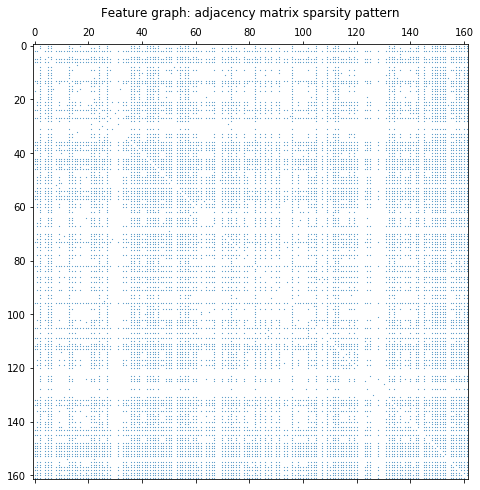

In [92]:
plt.figure(1, figsize=(8, 8))
plt.spy(A_feature_p3, markersize = 0.2)
plt.title('Feature graph: adjacency matrix sparsity pattern')

In [93]:
G_feature_p3 = nx.from_numpy_matrix(A_feature_p3)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature_p3.number_of_nodes(), G_feature_p3.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_feature_p3), nx.number_connected_components(G_feature_p3)))

Number of nodes: 162, Number of edges: 6281
Number of self-loops: 0, Number of connected components: 11


In [94]:
Gcc_p3 = sorted(nx.connected_components(G_feature_p3), key=len, reverse=True)
Gc_p3 = G_feature_p3.subgraph(Gcc_p3[0])
print('The giant component of the feature graph has {} nodes and {} edges.'.format(Gc_p3.number_of_nodes(), Gc_p3.size()))

The giant component of the feature graph has 151 nodes and 6280 edges.


Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 1910 to 1979(Label: Genre)')

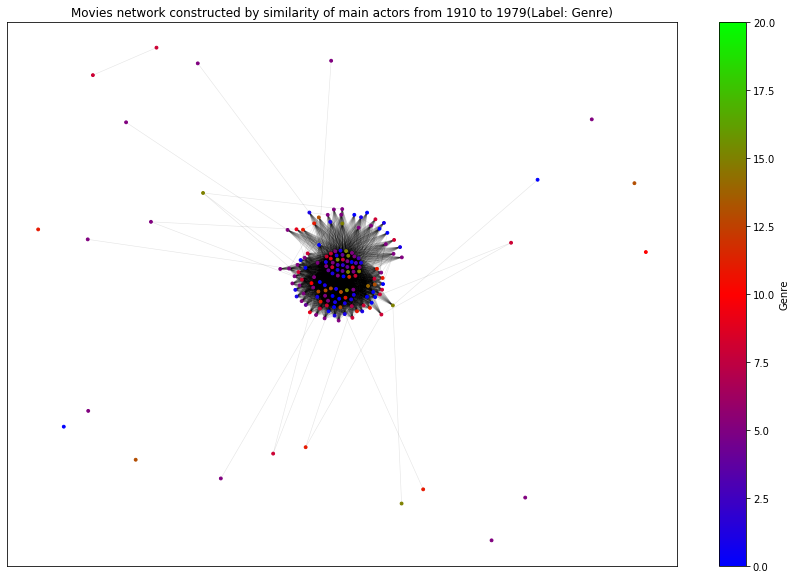

In [95]:
pos = nx.spring_layout(G_feature_p3, k=0.4)  # Force-directed layout.
# 
fig_mov_gen_p3 = plt.figure(figsize=(15, 10))
labels_genre_p3 = movie_p3['genre_id'].iloc[np.sort(nx.nodes(G_feature_p3))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p3, pos, node_size=8, node_color=labels_genre_p3, cmap='brg',vmin=0, vmax=20)
cbar = plt.colorbar(img)
cbar.set_label('Genre')
nx.draw_networkx_edges(G_feature_p3, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 1910 to 1979(Label: Genre)')
#fig_mov_gen_p3.savefig('./Figure/movie_gen_p3.png')

Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 1910 to 1979(Label: Success Label)')

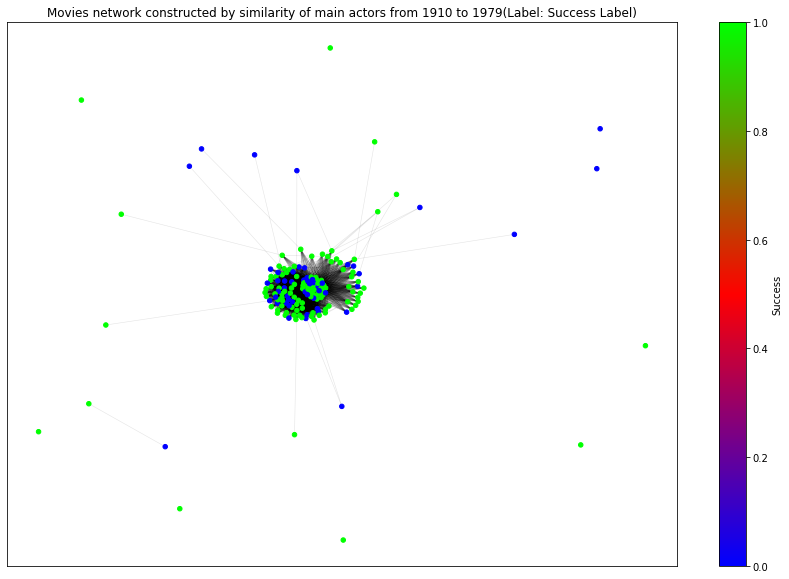

In [96]:
pos = nx.spring_layout(G_feature_p3, k=0.3)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_suc_p3 = movie_p2['success'].iloc[np.sort(nx.nodes(G_feature_p3))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p3, pos, node_size=20, node_color=labels_suc_p3, cmap='brg',vmin=0, vmax=1)
cbar = plt.colorbar(img)

cbar.set_label('Success')
nx.draw_networkx_edges(G_feature_p3, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 1910 to 1979(Label: Success Label)')

In [97]:
labels_suc_total_p3 = movie_p3['success'].iloc[np.sort(nx.nodes(G_feature_p3))]
r_suc_total_p3 = sum(labels_suc_total_p3)/len(labels_suc_total_p3)
labels_suc_Gc_p3 = movie_p3['success'].iloc[np.sort(nx.nodes(Gc_p3))]
r_suc_Gc_p3 = sum(labels_suc_Gc_p3)/len(labels_suc_Gc_p3)
print('The success ratio in total is {} and the success ratio of the Giant component is {}.'.format(r_suc_total_p3, r_suc_Gc_p3))

The success ratio in total is 0.8827160493827161 and the success ratio of the Giant component is 0.8807947019867549.


In [100]:
labels_ROI_total_p3 = movie_p3['ROI'].iloc[np.sort(nx.nodes(G_feature_p3))]
ROI_avr_total_p3 = sum(labels_ROI_total_p3)/len(labels_ROI_total_p3)
labels_ROI_Gc_p3 = movie_p3['ROI'].iloc[np.sort(nx.nodes(Gc_p3))]
ROI_avr_Gc_p3 = sum(labels_ROI_Gc_p3)/len(labels_ROI_Gc_p3)
print('The average ROI in total is {} and the average ROI of the Giant component is {}.'.format(ROI_avr_total_p3, ROI_avr_Gc_p3))

The average ROI in total is 29.644761507946246 and the average ROI of the Giant component is 31.45967093561409.


Text(0.5, 1.0, 'Movies network constructed by similarity of main actors from 1910 to 1979(Label: ROI)')

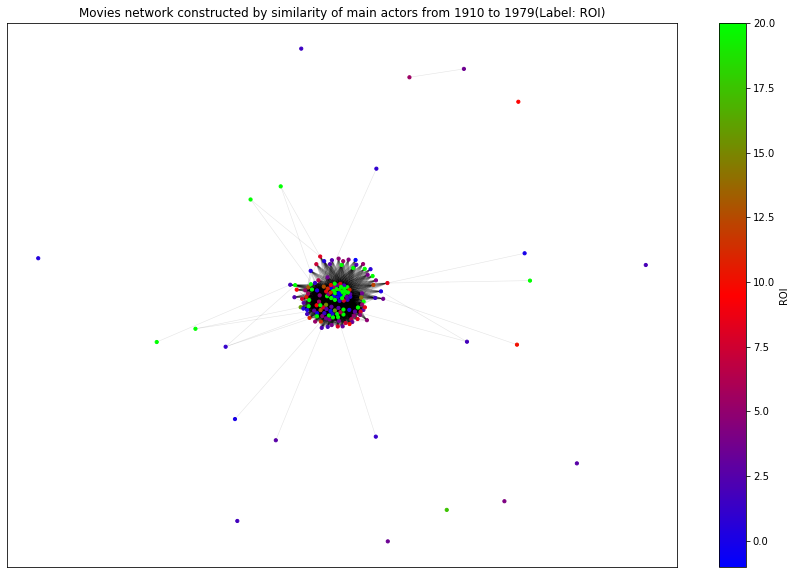

In [102]:
pos = nx.spring_layout(G_feature_p3, k=0.3)  # Force-directed layout.
# 
fig = plt.figure(figsize=(15, 10))
labels_ROI_p3 = movie_p3['ROI'].iloc[np.sort(nx.nodes(G_feature_p3))]
#pos = layout(G_feature_p1)
img = nx.draw_networkx_nodes(G_feature_p3, pos, node_size=10, node_color=labels_ROI_p3, cmap='brg',vmin=-1, vmax=20)
cbar = plt.colorbar(img)
cbar.set_label('ROI')
nx.draw_networkx_edges(G_feature_p3, pos, alpha=0.1, width=0.6)
plt.title('Movies network constructed by similarity of main actors from 1910 to 1979(Label: ROI)')

In [103]:
labels_score_total_p3 = movie_p3['vote_average'].iloc[np.sort(nx.nodes(G_feature_p3))]
score_avr_total_p3 = sum(labels_score_total_p3)/len(labels_score_total_p3)
labels_score_Gc_p3 = movie_p3['vote_average'].iloc[np.sort(nx.nodes(Gc_p3))]
score_avr_Gc_p3 = sum(labels_score_Gc_p3)/len(labels_score_Gc_p3)
print('The average score in total is {} and the average score of the Giant component is {}.'.format(score_avr_total_p3, score_avr_Gc_p3))

The average score in total is 7.154320987654321 and the average score of the Giant component is 7.128476821192052.


Compute proportion of the giant component of every period.

In [104]:
len(Gc_p1)/len(G_feature_p1)

0.3657858136300417

In [105]:
len(Gc_p2)/len(G_feature_p2)

0.5712166172106825

In [106]:
len(Gc_p3)/len(G_feature_p3)

0.9320987654320988

### Construct graph with Gauss kernel and analysis with graph signal

In [107]:
# Functions to compute adjacency matrix with gauss kernel
def epsilon_similarity_graph(X: np.ndarray, sigma):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    # Your code here
    n = X.shape[0]
    adjacency = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                adjacency[i, j] = np.exp(-1.0 * (np.linalg.norm(X[i]-X[j])**2) / (2 * (sigma**2)))
            if i == j:
                adjacency[i, j] = 0
    

    #adjacency[adjacency < epsilon] = 0
        
    return adjacency

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """

    w, v = np.linalg.eig(laplacian) # w - eigenvalues, v - eigenvectors

    lamb = np.sort(w)
    arg_w_sort = np.argsort(w)
    U = np.zeros(v.shape)

    for i in range(v.shape[1]):
        U[:,i] = v[:,arg_w_sort[i]]
    
    return lamb, U
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # Your code here
    n = adjacency.shape[0]
    L = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if normalize == False:
                # if the same vertice -> degree
                if i == j:
                    L[i, j] = np.sum(adjacency[i,:])
                # if not the same vertice and there is an edge or none between i and j
                else:
                    L[i, j] = - adjacency[i, j]
            elif normalize == True:
                if i == j:
                    L[i, j] = 1
                elif adjacency[i, j] == 0:
                    L[i, j] = 0
                else:
                    deg_i = np.sum(adjacency[i,:])
                    deg_j = np.sum(adjacency[j,:])
                    L[i, j] = -adjacency[i, j] / np.sqrt(deg_i * deg_j)
    
    return L

def GFT(U ,signal: np.ndarray):
    x_i = U.T.dot(signal)
    return x_i# Your code here

def iGFT(U, fourier_coefficients: np.ndarray):
    # Your code here
    x_i = U.dot(signal)
    return x_i

Construct graph with gauss kernel 

In [108]:
sigma = 0.5
epsilon = np.exp(-(1.8**2)/(2 * (sigma**2)))
distance_gauss_p1 = epsilon_similarity_graph(features_p1, sigma)
distance_gauss_p2 = epsilon_similarity_graph(features_p2, sigma)
distance_gauss_p3 = epsilon_similarity_graph(features_p3, sigma)

In [109]:
A_feature_gauss_p1 = distance_gauss_p1.copy()
A_feature_gauss_p1[A_feature_gauss_p1 < epsilon] = 0
A_feature_gauss_p2 = distance_gauss_p2.copy()
A_feature_gauss_p2[A_feature_gauss_p2 < epsilon] = 0
A_feature_gauss_p3 = distance_gauss_p3.copy()
A_feature_gauss_p3[A_feature_gauss_p3 < epsilon] = 0

Visualization of new ajaccency matrix of period 2

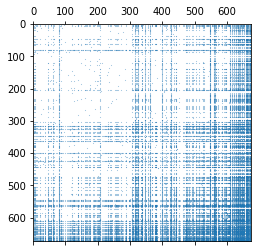

(674, 674)

In [111]:
plt.spy(A_feature_gauss_p2, markersize = 0.1)
plt.show()
A_feature_gauss_p2.shape

Compute Laplacian matrix of three new graphs

In [112]:
laplacian_comb_p1 = compute_laplacian(A_feature_gauss_p1, normalize=False)
laplacian_norm_p1 = compute_laplacian(A_feature_gauss_p1, normalize=True)
laplacian_comb_p2 = compute_laplacian(A_feature_gauss_p2, normalize=False)
laplacian_norm_p2 = compute_laplacian(A_feature_gauss_p2, normalize=True)
laplacian_comb_p3 = compute_laplacian(A_feature_gauss_p3, normalize=False)
laplacian_norm_p3 = compute_laplacian(A_feature_gauss_p3, normalize=True)

Spectral decomposition of three graphs

In [113]:
lamb_comb_p1, U_comb_p1 = spectral_decomposition(laplacian_comb_p1)
lamb_norm_p1, U_norm_p1 = spectral_decomposition(laplacian_norm_p1)
lamb_comb_p2, U_comb_p2 = spectral_decomposition(laplacian_comb_p2)
lamb_norm_p2, U_norm_p2 = spectral_decomposition(laplacian_norm_p2)
lamb_comb_p3, U_comb_p3 = spectral_decomposition(laplacian_comb_p3)
lamb_norm_p3, U_norm_p3 = spectral_decomposition(laplacian_norm_p3)

C:\Users\wangz\Anaconda3\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


Convert format

In [114]:
G_feature_gauss_p1 = nx.from_numpy_matrix(A_feature_gauss_p1)
G_feature_gauss_p2 = nx.from_numpy_matrix(A_feature_gauss_p2)
G_feature_gauss_p3 = nx.from_numpy_matrix(A_feature_gauss_p3)

Extract giant component from new graphs

In [115]:
Gcc_gauss_p1 = sorted(nx.connected_components(G_feature_gauss_p1), key=len, reverse=True)
Gc_gauss_p1 = G_feature_gauss_p1.subgraph(Gcc_p1[0])
print('The giant component of the feature graph p1 has {} nodes and {} edges.'.format(Gc_gauss_p1.number_of_nodes(), Gc_gauss_p1.size()))
Gcc_gauss_p2 = sorted(nx.connected_components(G_feature_gauss_p2), key=len, reverse=True)
Gc_gauss_p2 = G_feature_gauss_p2.subgraph(Gcc_p2[0])
print('The giant component of the feature graph p2 has {} nodes and {} edges.'.format(Gc_gauss_p2.number_of_nodes(), Gc_gauss_p2.size()))
Gcc_gauss_p3 = sorted(nx.connected_components(G_feature_gauss_p3), key=len, reverse=True)
Gc_gauss_p3 = G_feature_gauss_p3.subgraph(Gcc_p2[0])
print('The giant component of the feature graph has {} nodes and {} edges.'.format(Gc_gauss_p3.number_of_nodes(), Gc_gauss_p3.size()))

The giant component of the feature graph p1 has 789 nodes and 59523 edges.
The giant component of the feature graph p2 has 385 nodes and 15831 edges.
The giant component of the feature graph has 75 nodes and 1254 edges.


In [116]:
A_Gc_gauss_p1 = nx.to_numpy_matrix(Gc_gauss_p1)
A_Gc_gauss_p2 = nx.to_numpy_matrix(Gc_gauss_p2)
A_Gc_gauss_p3 = nx.to_numpy_matrix(Gc_gauss_p3)

In [117]:
laplacian_norm_Gc_p1 = compute_laplacian(A_Gc_gauss_p1, normalize=True)
lamb_norm_Gc_p1, U_norm_Gc_p1 = spectral_decomposition(laplacian_norm_Gc_p1)
laplacian_norm_Gc_p2 = compute_laplacian(A_Gc_gauss_p2, normalize=True)
lamb_norm_Gc_p2, U_norm_Gc_p2 = spectral_decomposition(laplacian_norm_Gc_p2)
laplacian_norm_Gc_p3 = compute_laplacian(A_Gc_gauss_p3, normalize=True)
lamb_norm_Gc_p3, U_norm_Gc_p3 = spectral_decomposition(laplacian_norm_Gc_p3)

C:\Users\wangz\Anaconda3\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


Extract ROI signal from original graph 

In [118]:
signals_ROI_Gc_p1 = movie_p1['ROI'].iloc[np.sort(nx.nodes(Gc_gauss_p1))]
signals_ROI_Gc_p2 = movie_p2['ROI'].iloc[np.sort(nx.nodes(Gc_gauss_p2))]
signals_ROI_Gc_p3 = movie_p3['ROI'].iloc[np.sort(nx.nodes(Gc_gauss_p3))]

Extract success signal from original graphs

In [119]:
signals_suc_Gc_p1 = movie_p1['success'].iloc[np.sort(nx.nodes(Gc_gauss_p1))]
signals_suc_Gc_p2 = movie_p2['success'].iloc[np.sort(nx.nodes(Gc_gauss_p2))]
signals_suc_Gc_p3 = movie_p3['success'].iloc[np.sort(nx.nodes(Gc_gauss_p3))]

Plot GFT of success signal of giant component in three periods

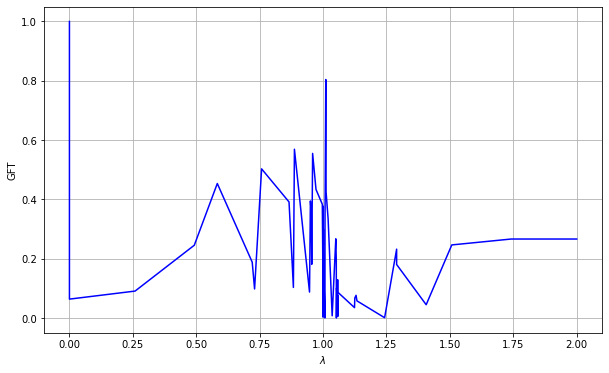

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(lamb_norm_Gc_p3, np.abs(GFT(U_norm_Gc_p3, signals_suc_Gc_p3))/max(np.abs(GFT(U_norm_Gc_p3, signals_suc_Gc_p3))), 'b-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.grid()

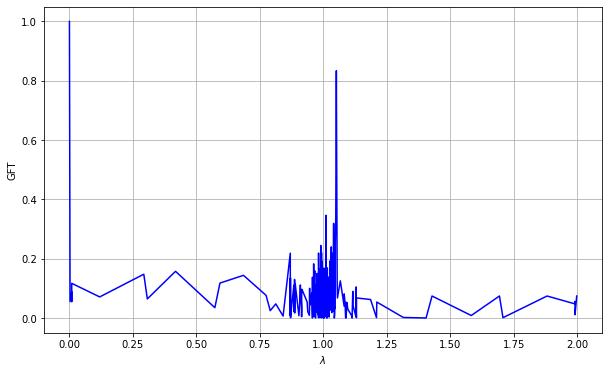

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(lamb_norm_Gc_p1, np.abs(GFT(U_norm_Gc_p1, signals_suc_Gc_p1))/max(np.abs(GFT(U_norm_Gc_p1, signals_suc_Gc_p1))), 'b-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.grid()

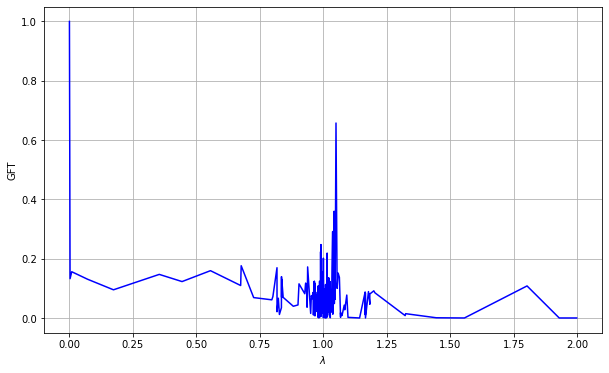

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(lamb_norm_Gc_p2, np.abs(GFT(U_norm_Gc_p2, signals_suc_Gc_p2))/max(np.abs(GFT(U_norm_Gc_p2, signals_suc_Gc_p2))), 'b-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.grid()

In [124]:
signals_suc_Gc_p1_np = signals_suc_Gc_p1.to_numpy().reshape((1,len(signals_suc_Gc_p1)))
signals_suc_Gc_p2_np = signals_suc_Gc_p2.to_numpy().reshape((1,len(signals_suc_Gc_p2)))
signals_suc_Gc_p3_np = signals_suc_Gc_p3.to_numpy().reshape((1,len(signals_suc_Gc_p3)))

Compute the Laplacian quadratic form of three giant components

In [125]:
laplace2nd_suc_p1 = (signals_suc_Gc_p1_np.dot(laplacian_norm_Gc_p1).dot(signals_suc_Gc_p1_np.transpose()))/len(signals_suc_Gc_p1)
laplace2nd_suc_p2 = (signals_suc_Gc_p2_np.dot(laplacian_norm_Gc_p2).dot(signals_suc_Gc_p2_np.transpose()))/len(signals_suc_Gc_p2)
laplace2nd_suc_p3 = (signals_suc_Gc_p3_np.dot(laplacian_norm_Gc_p3).dot(signals_suc_Gc_p3_np.transpose()))/len(signals_suc_Gc_p3)

In [126]:
laplace2nd_suc_p1

array([[0.51007071]])

In [127]:
laplace2nd_suc_p2

array([[0.46255045]])

In [128]:
laplace2nd_suc_p3

array([[0.47081284]])

### Visulization

In [129]:
# ROI
bar_ROI = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add_xaxis(["1910-1979", "1980-1999", "2000-2016"])
    .add_yaxis("Total", [29.6448, 4.0897, 3.0458],category_gap="60%")
    .add_yaxis("Giant component", [31.4597, 4.5574,4.9289],category_gap="60%")
    .set_global_opts(title_opts=opts.TitleOpts(title="ROI"))
)
bar_ROI.load_javascript()

In [130]:
bar_ROI.render_notebook()
#make_snapshot(snapshot, bar_ROI.render(), "./Figure/ROI.png")

In [131]:
# Average rate
bar_score = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add_xaxis(["1910-1979", "1980-1999", "2000-2016"])
    .add_yaxis("Total", [7.1543,6.4708,6.2478],category_gap="60%")
    .add_yaxis("Giant component", [7.1285,6.4221,6.2625],category_gap="60%")
    .set_global_opts(title_opts=opts.TitleOpts(title="Average score"))
)
bar_score.load_javascript()

In [132]:
bar_score.render_notebook()
#make_snapshot(snapshot, bar_score.render(), "./Figure/score.png")

In [133]:
# Ratio of Gc
bar_ratio = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add_xaxis(["1910-1979", "1980-1999", "2000-2016"])
    .add_yaxis("Total",[0.9321,0.5712,0.3658],category_gap="70%")
    .set_global_opts(title_opts=opts.TitleOpts(title="Proportion of giant component"))
)


bar_score.load_javascript()

In [134]:
bar_ratio.render_notebook()
#make_snapshot(snapshot, bar_ratio.render(), "./Figure/ratio.png")

In [135]:
# 2nd Laplace
bar_suc = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add_xaxis(["1910-1979", "1980-1999", "2000-2016"])
    .add_yaxis("Total",[0.4708,0.4626,0.5101],category_gap="70%")
    .set_global_opts(title_opts=opts.TitleOpts(title="Laplacian quadratic form of success signal"))
)


bar_suc.load_javascript()

In [136]:
bar_suc.render_notebook()
#make_snapshot(snapshot, bar_suc.render(), "./Figure/suc.png")